In [2]:
import argparse
import os
from typing import Hashable
from pandas.core.series import Series
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# import sys
# import pickle
# from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


from sklearn.model_selection import train_test_split
import seaborn as sns
import torch

# import torchvision
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights, ResNet50_Weights

import torchvision.models as models
import os
import psutil

# import cv2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# import seaborn as sns
import os

from PIL import Image
from tqdm import tqdm

import torch
import torchvision.models as models
import torch.nn as nn
import os
from PIL import Image
import io
import torchvision.transforms as transforms
import json

import boto3
import sagemaker
from sagemaker.pytorch import PyTorch, PyTorchModel
import datetime
import json


sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/amannindra/Library/Application Support/sagemaker/config.yaml


In [3]:
# Configuration
REGION = 'us-west-1'
ROLE_ARN = "arn:aws:iam::253490779227:role/service-role/AmazonSageMakerAdminIAMExecutionRole"
BUCKET = 'animal-classification-dss-works'
S3_INPUT_DATA = f's3://{BUCKET}/data/'
S3_PREPROCESSED = f's3://{BUCKET}/processed'
S3_SHORT_PREPROCESSED = f's3://{BUCKET}/short_processed'


In [10]:

def to_hwc3(img: np.ndarray) -> np.ndarray:
    if img.ndim == 2:  # (H, W) -> (H, W, 3)
        return np.repeat(img[..., None], 3, axis=2)
    if img.ndim == 3:
        if img.shape[2] == 1:  # (H, W, 1) -> (H, W, 3)
            return np.repeat(img, 3, axis=2)
        if img.shape[2] >= 3:  # (H, W, 3) or (H, W, 4) -> keep first 3
            return img[..., :3]
    raise ValueError(f"Unexpected shape: {img.shape}")





In [11]:
train_file = "resnet18/output/train_metrics.json"
val_file = "resnet18/output/val_metrics.json"

if os.path.exists(train_file):
    with open(train_file, 'r') as f:
        train_metrics = json.load(f)

if os.path.exists(val_file):
    with open(val_file, 'r') as f:
        val_metrics = json.load(f)
        
class_names = [
        "antelope_duiker",
        "bird",
        "blank",
        "civet_genet",
        "hog",
        "leopard",
        "monkey_prosimian",
        "rodent",
    ]
        
class_names = np.array(class_names)

<Figure size 1500x2000 with 0 Axes>

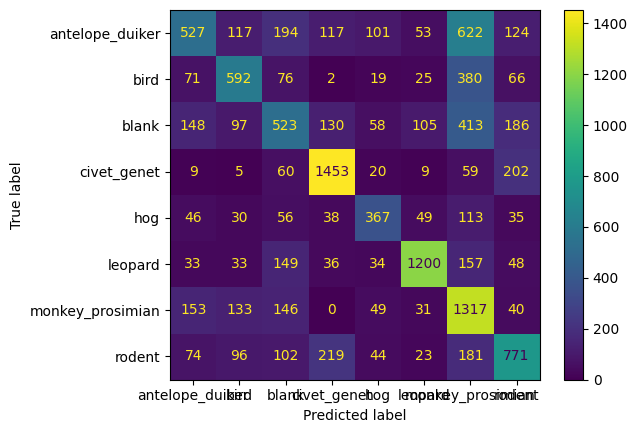

In [12]:
cm = train_metrics[0]["confusion_matrix"]
cm = np.array(cm)
figure = plt.figure(figsize=(15, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot()
plt.show()


<Figure size 1500x2000 with 0 Axes>

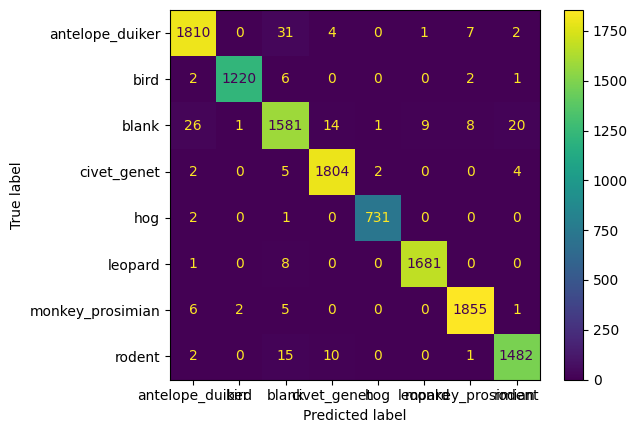

In [13]:
cm = train_metrics[9]["confusion_matrix"]
cm = np.array(cm)
figure = plt.figure(figsize=(15, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot()
plt.show()


In [14]:
loss = []
acc = []
antelope_duiker_f1 = []
bird_f1 = []
blank_f1 = []
civet_genet_f1 = []
hog_f1 = []
leopard_f1 = []
monkey_prosimian_f1 = []
rodent_f1 = []

for i in range(len(train_metrics)):
    loss.append(train_metrics[i]["loss"])
    acc.append(train_metrics[i]["acc"])
    antelope_duiker_f1.append(train_metrics[i]["class_f1s"]["antelope_duiker"])
    bird_f1.append(train_metrics[i]["class_f1s"]["bird"])
    blank_f1.append(train_metrics[i]["class_f1s"]["blank"])
    civet_genet_f1.append(train_metrics[i]["class_f1s"]["civet_genet"])
    hog_f1.append(train_metrics[i]["class_f1s"]["hog"])
    leopard_f1.append(train_metrics[i]["class_f1s"]["leopard"])
    monkey_prosimian_f1.append(train_metrics[i]["class_f1s"]["monkey_prosimian"])
    rodent_f1.append(train_metrics[i]["class_f1s"]["rodent"])
    
    


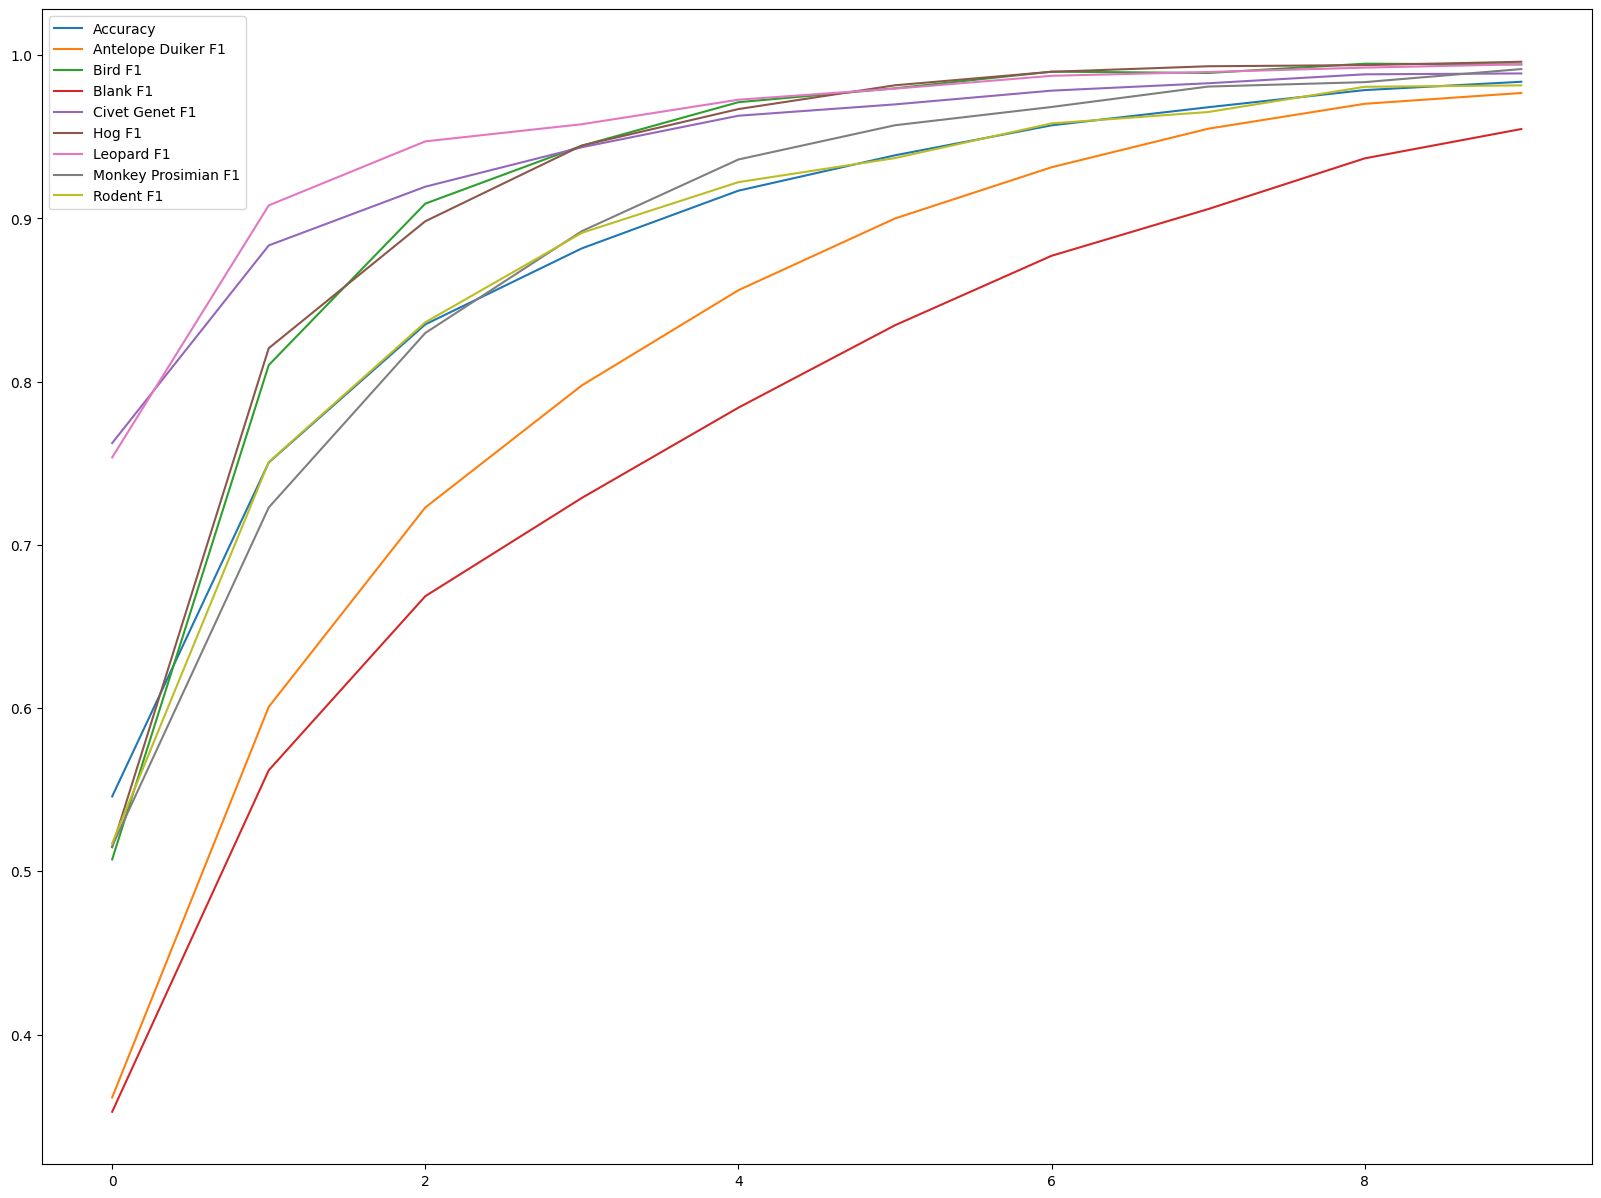

In [15]:
figure = plt.figure(figsize=(20, 15))
plt.plot(acc, label='Accuracy')
plt.plot(antelope_duiker_f1, label='Antelope Duiker F1')
plt.plot(bird_f1, label='Bird F1')
plt.plot(blank_f1, label='Blank F1')
plt.plot(civet_genet_f1, label='Civet Genet F1')
plt.plot(hog_f1, label='Hog F1')
plt.plot(leopard_f1, label='Leopard F1')
plt.plot(monkey_prosimian_f1, label='Monkey Prosimian F1')
plt.plot(rodent_f1, label='Rodent F1')
plt.legend()
plt.show()


In [16]:
val_loss = []
val_acc = []
val_antelope_duiker_f1 = []
val_bird_f1 = []
val_blank_f1 = []
val_civet_genet_f1 = []
val_hog_f1 = []
val_leopard_f1 = []
val_monkey_prosimian_f1 = []
val_rodent_f1 = []

for i in range(len(val_metrics)):
    val_loss.append(val_metrics[i]["loss"])
    val_acc.append(val_metrics[i]["acc"])
    val_antelope_duiker_f1.append(val_metrics[i]["class_f1s"]["antelope_duiker"])
    val_bird_f1.append(val_metrics[i]["class_f1s"]["bird"])
    val_blank_f1.append(val_metrics[i]["class_f1s"]["blank"])
    val_civet_genet_f1.append(val_metrics[i]["class_f1s"]["civet_genet"])
    val_hog_f1.append(val_metrics[i]["class_f1s"]["hog"])
    val_leopard_f1.append(val_metrics[i]["class_f1s"]["leopard"])
    val_monkey_prosimian_f1.append(val_metrics[i]["class_f1s"]["monkey_prosimian"])
    val_rodent_f1.append(val_metrics[i]["class_f1s"]["rodent"])

    


<Figure size 1500x2000 with 0 Axes>

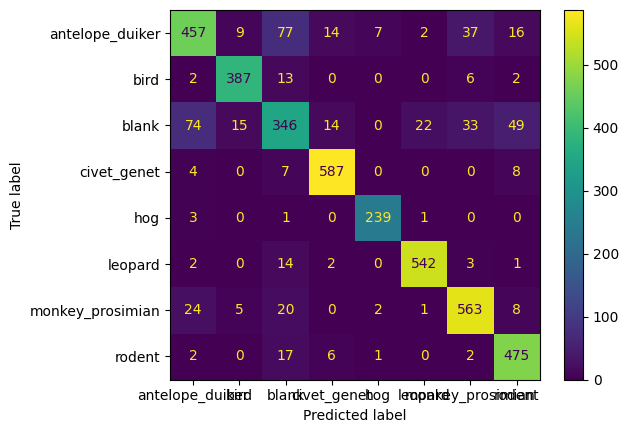

In [17]:
cm = val_metrics[4]["confusion_matrix"]
cm = np.array(cm)
figure = plt.figure(figsize=(15, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot()
plt.show()


<Figure size 1500x2000 with 0 Axes>

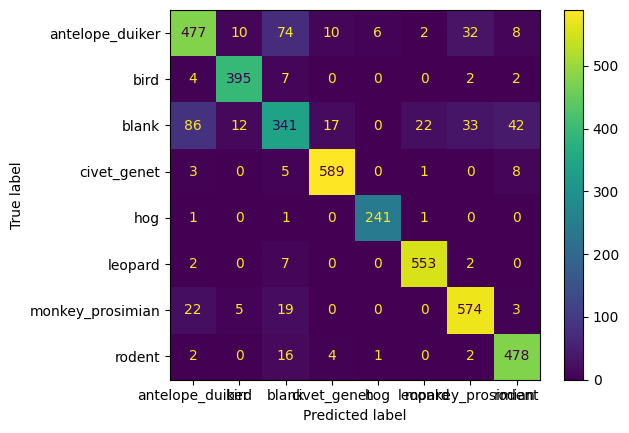

In [21]:
cm = val_metrics[9]["confusion_matrix"]
cm = np.array(cm)
figure = plt.figure(figsize=(15, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot()
plt.show()


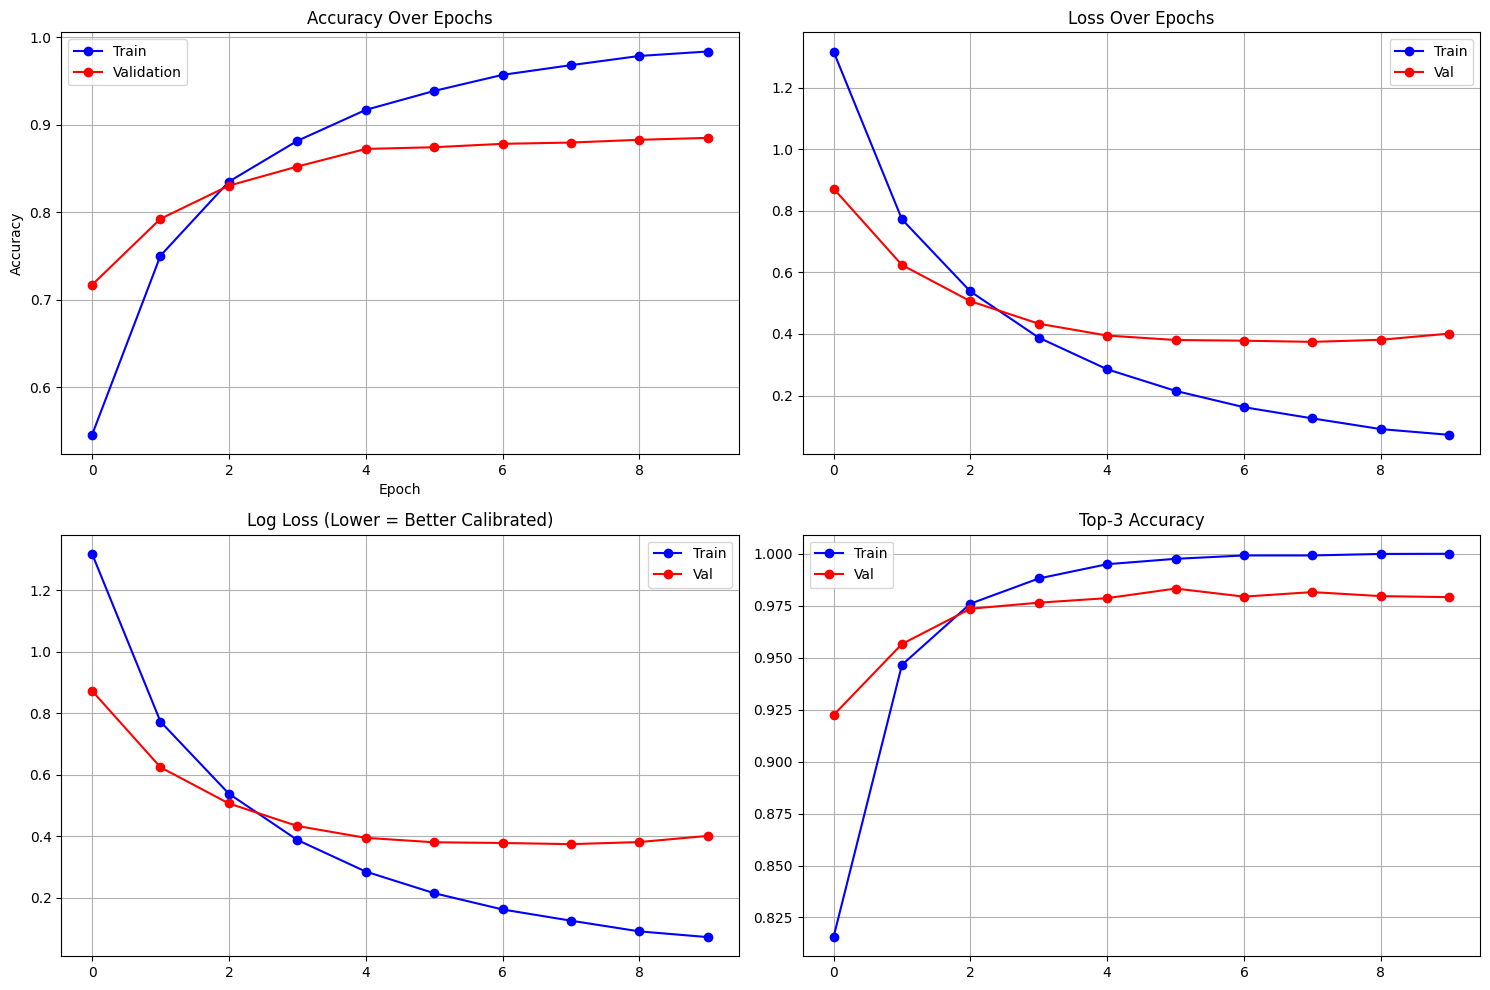

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
train_df = pd.read_csv('resnet18/output/train_metrics.csv')
val_df = pd.read_csv('resnet18/output/val_metrics.csv')
# Accuracy over time
axes[0,0].plot(train_df['epoch'], train_df['acc'], 'b-o', label='Train')
axes[0,0].plot(val_df['epoch'], val_df['acc'], 'r-o', label='Validation')
axes[0,0].set_title('Accuracy Over Epochs')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True)

# Loss over time
axes[0,1].plot(train_df['epoch'], train_df['loss'], 'b-o', label='Train')
axes[0,1].plot(val_df['epoch'], val_df['loss'], 'r-o', label='Val')
axes[0,1].set_title('Loss Over Epochs')
axes[0,1].legend()
axes[0,1].grid(True)

# Log Loss (confidence quality)
axes[1,0].plot(train_df['epoch'], train_df['log_loss'], 'b-o', label='Train')
axes[1,0].plot(val_df['epoch'], val_df['log_loss'], 'r-o', label='Val')
axes[1,0].set_title('Log Loss (Lower = Better Calibrated)')
axes[1,0].legend()
axes[1,0].grid(True)

# Top-3 Accuracy
axes[1,1].plot(train_df['epoch'], train_df['top3_accuracy'], 'b-o', label='Train')
axes[1,1].plot(val_df['epoch'], val_df['top3_accuracy'], 'r-o', label='Val')
axes[1,1].set_title('Top-3 Accuracy')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

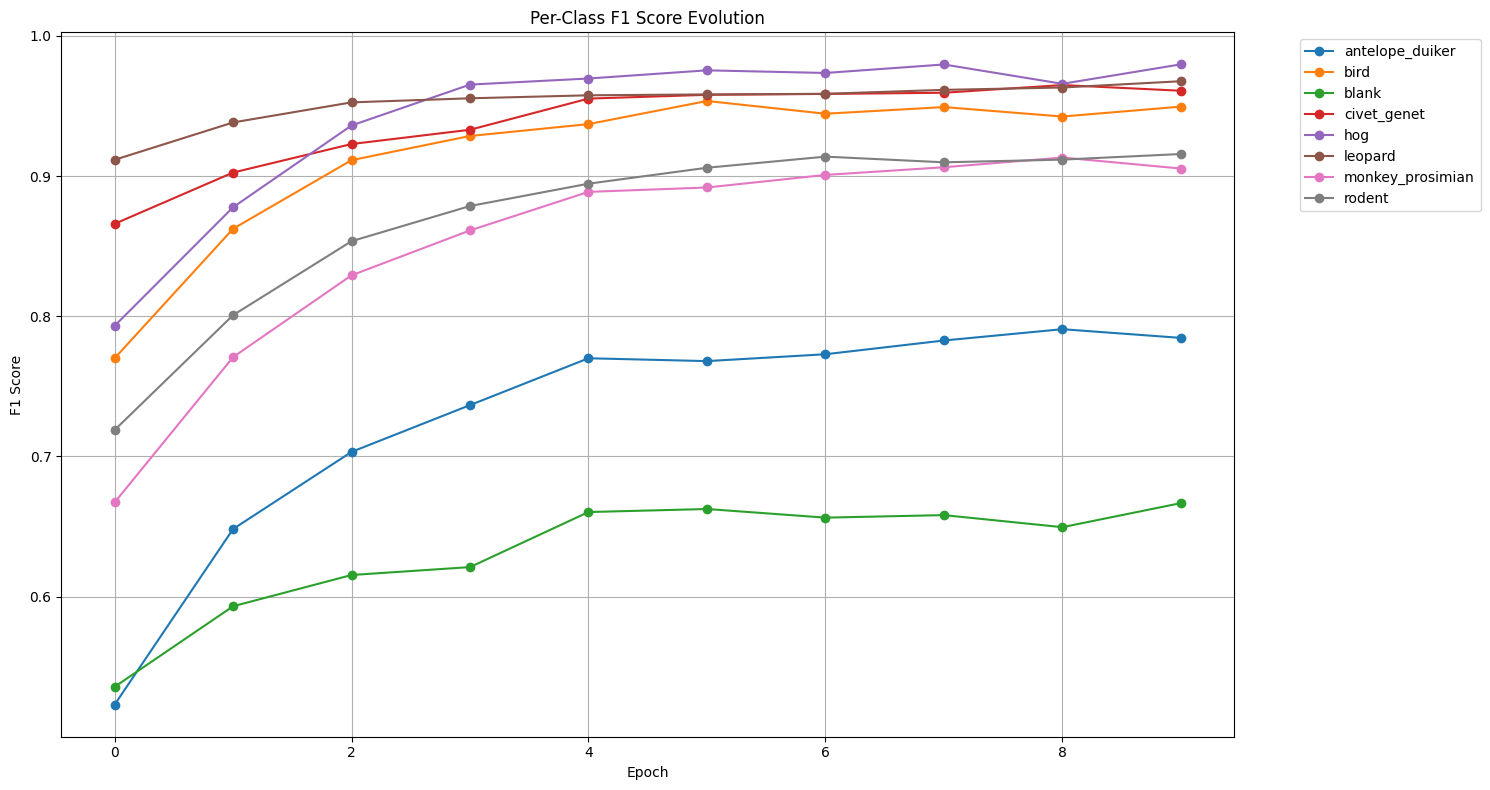

In [75]:
plt.figure(figsize=(15, 8))
for class_name in class_names:
    f1_scores = [epoch['class_f1s'][class_name] for epoch in val_metrics]
    plt.plot(range(len(f1_scores)), f1_scores, marker='o', label=class_name)

plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Per-Class F1 Score Evolution')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

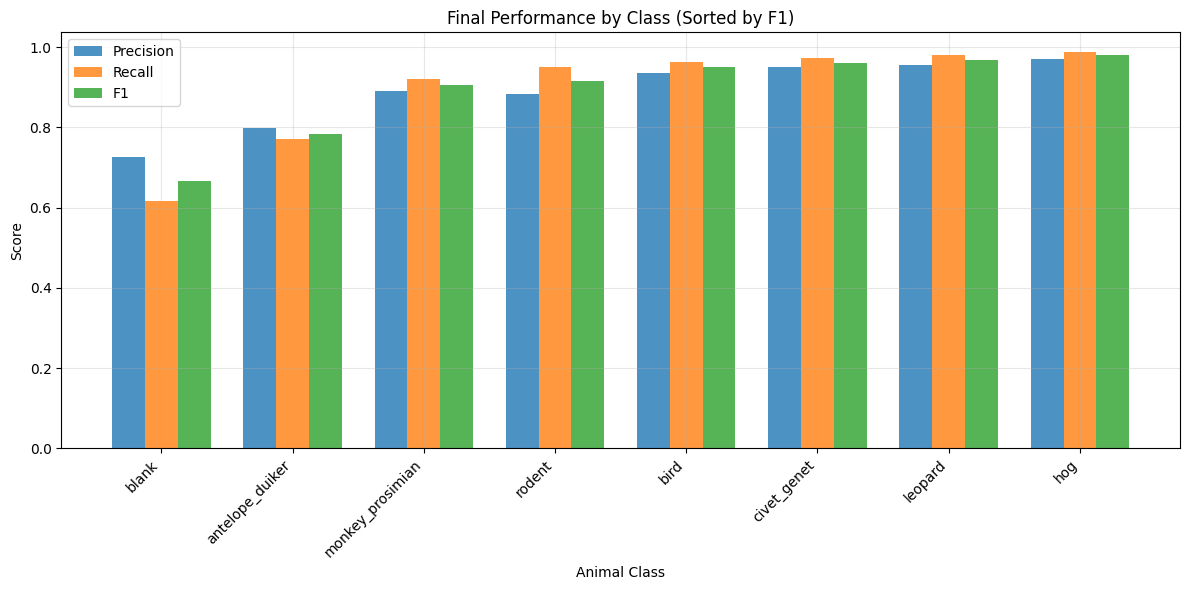


🔴 Hardest Classes (Lowest F1):
              Class        F1  Precision    Recall
2             blank  0.666667   0.725532  0.616637
0   antelope_duiker  0.784539   0.798995  0.770598
6  monkey_prosimian  0.905363   0.889922  0.921348


In [76]:
final_metrics = val_metrics[-1]

class_performance = []
for class_name in class_names:
    class_performance.append({
        'Class': class_name,
        'F1': final_metrics['class_f1s'][class_name],
        'Precision': final_metrics['class_precisions'][class_name],
        'Recall': final_metrics['class_recalls'][class_name],
        'Confidence': final_metrics['class_confidences'][class_name],
        'Support': final_metrics[class_name]['support']
    })

perf_df = pd.DataFrame(class_performance)
perf_df = perf_df.sort_values('F1')

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(perf_df))
width = 0.25

ax.bar(x - width, perf_df['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x, perf_df['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + width, perf_df['F1'], width, label='F1', alpha=0.8)

ax.set_xlabel('Animal Class')
ax.set_ylabel('Score')
ax.set_title('Final Performance by Class (Sorted by F1)')
ax.set_xticks(x)
ax.set_xticklabels(perf_df['Class'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🔴 Hardest Classes (Lowest F1):")
print(perf_df[['Class', 'F1', 'Precision', 'Recall']].head(3))

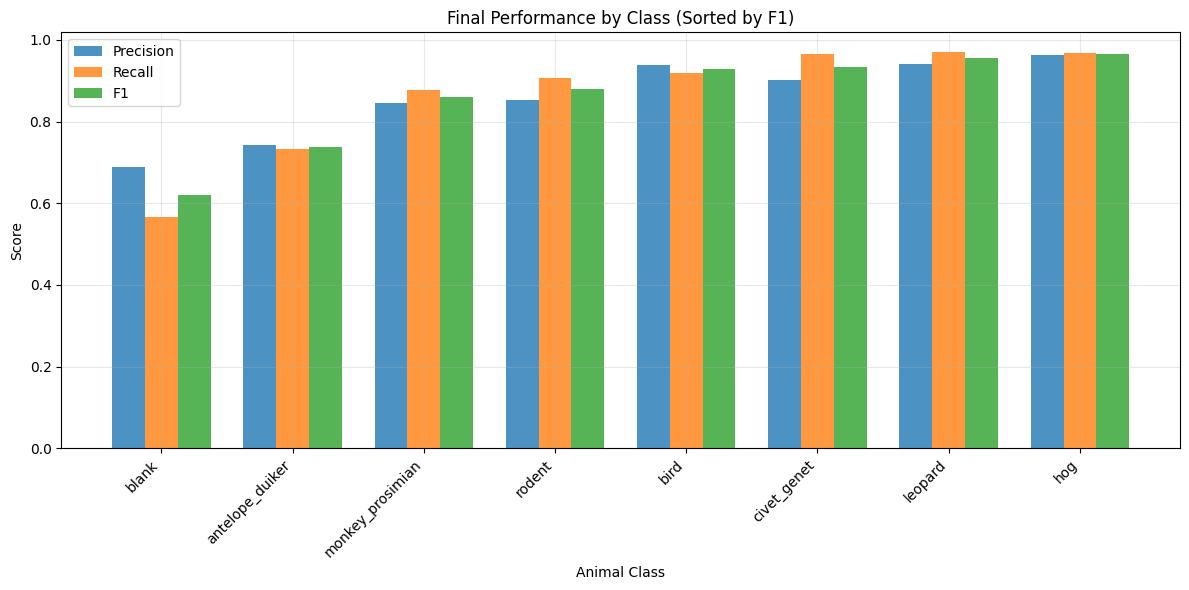


🔴 Hardest Classes (Lowest F1):
              Class        F1  Precision    Recall
2             blank  0.621032   0.687912  0.566004
0   antelope_duiker  0.736585   0.741408  0.731826
6  monkey_prosimian  0.861199   0.846512  0.876404


In [77]:
final_metrics = val_metrics[3]

class_performance = []
for class_name in class_names:
    class_performance.append({
        'Class': class_name,
        'F1': final_metrics['class_f1s'][class_name],
        'Precision': final_metrics['class_precisions'][class_name],
        'Recall': final_metrics['class_recalls'][class_name],
        'Confidence': final_metrics['class_confidences'][class_name],
        'Support': final_metrics[class_name]['support']
    })

perf_df = pd.DataFrame(class_performance)
perf_df = perf_df.sort_values('F1')

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(perf_df))
width = 0.25

ax.bar(x - width, perf_df['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x, perf_df['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + width, perf_df['F1'], width, label='F1', alpha=0.8)

ax.set_xlabel('Animal Class')
ax.set_ylabel('Score')
ax.set_title('Final Performance by Class (Sorted by F1)')
ax.set_xticks(x)
ax.set_xticklabels(perf_df['Class'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🔴 Hardest Classes (Lowest F1):")
print(perf_df[['Class', 'F1', 'Precision', 'Recall']].head(3))

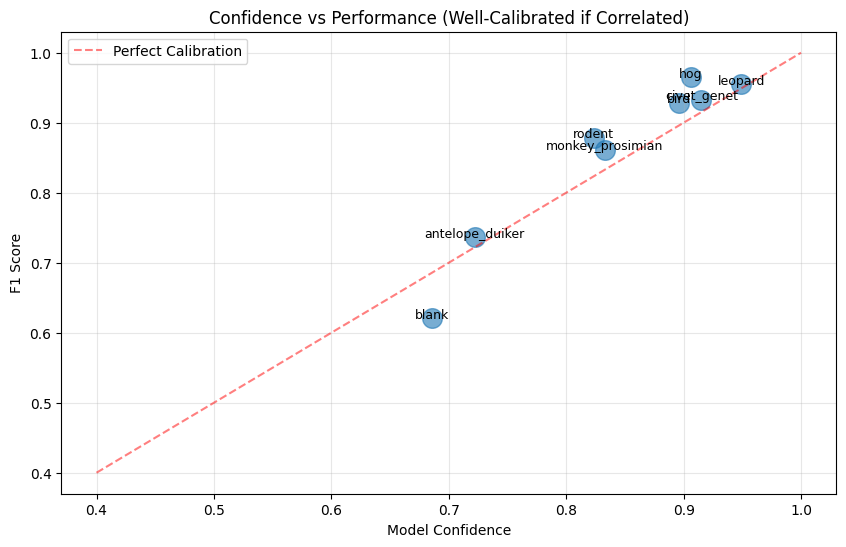


⚠️ Overconfident Classes (Confidence > Performance):
   Class  Confidence        F1  Calibration
2  blank    0.685657  0.621032     0.064626


In [78]:
plt.figure(figsize=(10, 6))
plt.scatter(perf_df['Confidence'], perf_df['F1'], s=200, alpha=0.6)

for idx, row in perf_df.iterrows():
    plt.annotate(row['Class'], 
                (row['Confidence'], row['F1']),
                fontsize=9, ha='center')

plt.xlabel('Model Confidence')
plt.ylabel('F1 Score')
plt.title('Confidence vs Performance (Well-Calibrated if Correlated)')
plt.grid(True, alpha=0.3)

# Add diagonal reference line
plt.plot([0.4, 1.0], [0.4, 1.0], 'r--', alpha=0.5, label='Perfect Calibration')
plt.legend()
plt.show()

# Identify over/under confident classes
perf_df['Calibration'] = perf_df['Confidence'] - perf_df['F1']
print("\n⚠️ Overconfident Classes (Confidence > Performance):")
print(perf_df[perf_df['Calibration'] > 0.05][['Class', 'Confidence', 'F1', 'Calibration']])


🔴 Top 10 Misclassifications:
            True        Predicted  Count  Pct_of_True
           blank  antelope_duiker     86    15.551537
 antelope_duiker            blank     74    11.954766
           blank           rodent     42     7.594937
           blank monkey_prosimian     33     5.967450
 antelope_duiker monkey_prosimian     32     5.169628
           blank          leopard     22     3.978300
monkey_prosimian  antelope_duiker     22     3.531300
monkey_prosimian            blank     19     3.049759
           blank      civet_genet     17     3.074141
          rodent            blank     16     3.180915


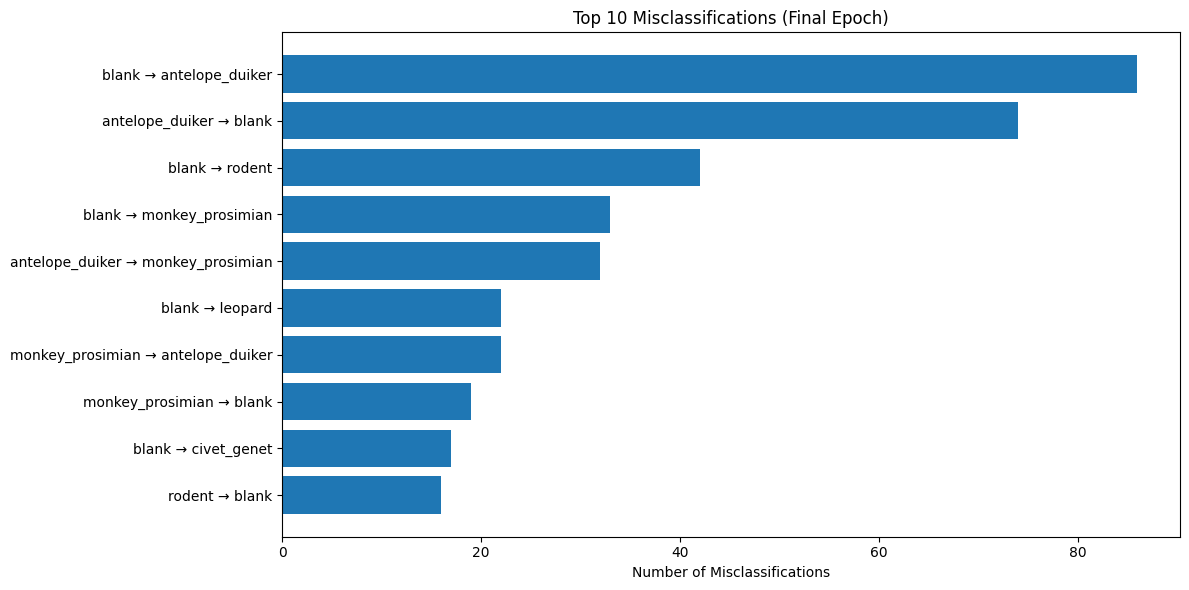

In [79]:
# Get final confusion matrix
cm = np.array(val_metrics[-1]['confusion_matrix'])

# Find top misclassifications (off-diagonal)
misclassifications = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j:  # Skip diagonal (correct predictions)
            misclassifications.append({
                'True': class_names[i],
                'Predicted': class_names[j],
                'Count': cm[i, j],
                'Pct_of_True': cm[i, j] / cm[i].sum() * 100
            })

misc_df = pd.DataFrame(misclassifications)
misc_df = misc_df.sort_values('Count', ascending=False)

print("\n🔴 Top 10 Misclassifications:")
print(misc_df.head(10).to_string(index=False))

# Visualize top confusions
top_misc = misc_df.head(10)
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_misc)), top_misc['Count'])
plt.yticks(range(len(top_misc)), 
          [f"{row['True']} → {row['Predicted']}" for _, row in top_misc.iterrows()])
plt.xlabel('Number of Misclassifications')
plt.title('Top 10 Misclassifications (Final Epoch)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [80]:
train_df['acc']

0    0.545852
1    0.750445
2    0.835032
3    0.881611
4    0.916950
5    0.938622
6    0.956979
7    0.968058
8    0.978570
9    0.983665
Name: acc, dtype: float64

In [81]:
val_df['acc']

0    0.717128
1    0.792576
2    0.830422
3    0.852256
4    0.872392
5    0.874333
6    0.878214
7    0.879670
8    0.882824
9    0.885007
Name: acc, dtype: float64

In [82]:
train_df = pd.read_csv('resnet18/output/train_metrics.csv')
train_df['acc']

0    0.545852
1    0.750445
2    0.835032
3    0.881611
4    0.916950
5    0.938622
6    0.956979
7    0.968058
8    0.978570
9    0.983665
Name: acc, dtype: float64

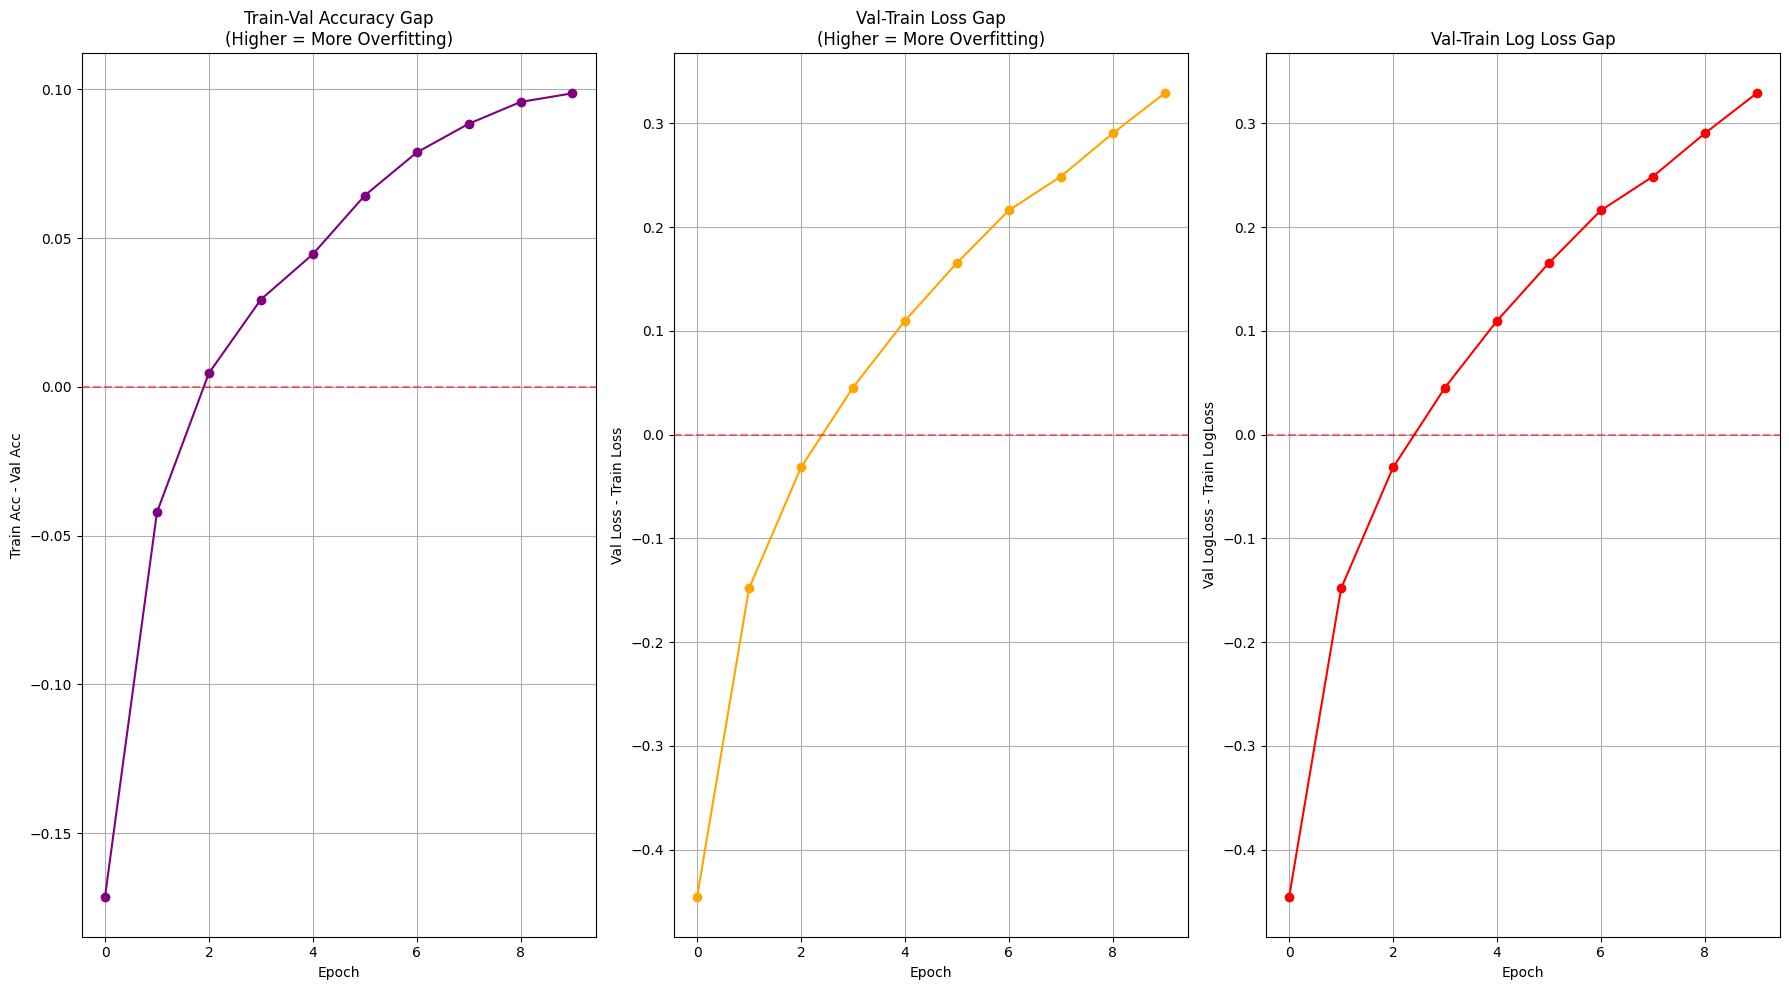


Final Overfitting Metrics (Epoch 9):
  Accuracy Gap: 0.0987 (⚠️ Overfitting)


In [84]:
train_df = pd.read_csv('resnet18/output/train_metrics.csv')
val_df = pd.read_csv('resnet18/output/val_metrics.csv')

gap_df = pd.DataFrame({
    'Epoch': train_df['epoch'],
    'Accuracy_Gap': train_df['acc'] - val_df['acc'],
    'Loss_Gap': val_df['loss'] - train_df['loss'],
    'LogLoss_Gap': val_df['log_loss'] - train_df['log_loss']
})

fig, axes = plt.subplots(1, 3, figsize=(18,10))

axes[0].plot(gap_df['Epoch'], gap_df['Accuracy_Gap'], 'o-', color='purple')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0].set_title('Train-Val Accuracy Gap\n(Higher = More Overfitting)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Train Acc - Val Acc')
axes[0].grid(True)

axes[1].plot(gap_df['Epoch'], gap_df['Loss_Gap'], 'o-', color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1].set_title('Val-Train Loss Gap\n(Higher = More Overfitting)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Val Loss - Train Loss')
axes[1].grid(True)

axes[2].plot(gap_df['Epoch'], gap_df['LogLoss_Gap'], 'o-', color='red')
axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[2].set_title('Val-Train Log Loss Gap')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Val LogLoss - Train LogLoss')
axes[2].grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal Overfitting Metrics (Epoch {len(train_df)-1}):")
print(f"  Accuracy Gap: {gap_df['Accuracy_Gap'].iloc[-1]:.4f} ({'⚠️ Overfitting' if gap_df['Accuracy_Gap'].iloc[-1] > 0.05 else '✅ Good'})")

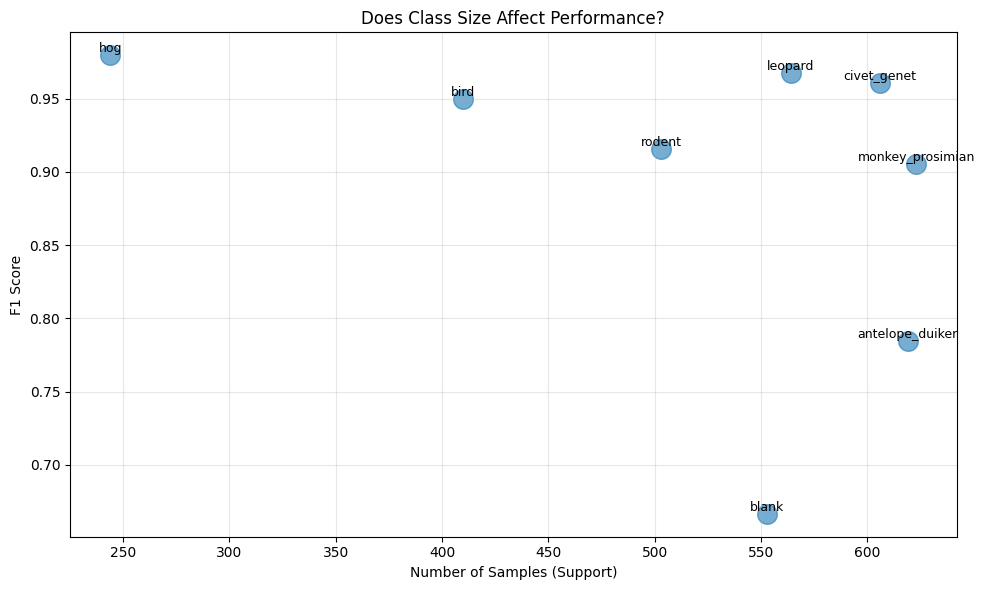


Correlation between class size and F1: -0.383
  > 0.5: Larger classes perform better ✅
  < 0.2: Performance independent of class size ⚠️


In [85]:
# Extract support (sample counts) from final epoch
supports = [val_metrics[-1][class_name]['support'] for class_name in class_names]
f1_scores = [val_metrics[-1]['class_f1s'][class_name] for class_name in class_names]

plt.figure(figsize=(10, 6))
plt.scatter(supports, f1_scores, s=200, alpha=0.6)

for i, class_name in enumerate(class_names):
    plt.annotate(class_name, (supports[i], f1_scores[i]), 
                fontsize=9, ha='center', va='bottom')

plt.xlabel('Number of Samples (Support)')
plt.ylabel('F1 Score')
plt.title('Does Class Size Affect Performance?')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation
corr = np.corrcoef(supports, f1_scores)[0, 1]
print(f"\nCorrelation between class size and F1: {corr:.3f}")
print("  > 0.5: Larger classes perform better ✅")
print("  < 0.2: Performance independent of class size ⚠️")

In [86]:
print("\n" + "="*60)
print("📊 TRAINING SUMMARY REPORT")
print("="*60)

print(f"\nModel: ResNet18")
print(f"Total Epochs: {len(val_metrics)}")
print(f"Best Val Accuracy: {val_df['acc'].max():.2%} (Epoch {val_df['acc'].idxmax()})")
print(f"Final Val Accuracy: {val_df['acc'].iloc[-1]:.2%}")
print(f"Top-3 Accuracy: {val_df['top3_accuracy'].iloc[-1]:.2%}")

print(f"\n🎯 Per-Class Performance (Final Epoch):")
final_perf = pd.DataFrame({
    'Class': class_names,
    'F1': [val_metrics[-1]['class_f1s'][c] for c in class_names],
    'Samples': [val_metrics[-1][c]['support'] for c in class_names]
}).sort_values('F1', ascending=False)
print(final_perf.to_string(index=False))

print(f"\n✅ Best Performing: {final_perf.iloc[0]['Class']} (F1={final_perf.iloc[0]['F1']:.3f})")
print(f"⚠️  Worst Performing: {final_perf.iloc[-1]['Class']} (F1={final_perf.iloc[-1]['F1']:.3f})")

print(f"\n📈 Training Progress:")
print(f"  Initial Val Acc: {val_df['acc'].iloc[0]:.2%}")
print(f"  Final Val Acc: {val_df['acc'].iloc[-1]:.2%}")
print(f"  Total Improvement: +{(val_df['acc'].iloc[-1] - val_df['acc'].iloc[0]):.2%}")


📊 TRAINING SUMMARY REPORT

Model: ResNet18
Total Epochs: 10
Best Val Accuracy: 88.50% (Epoch 9)
Final Val Accuracy: 88.50%
Top-3 Accuracy: 97.91%

🎯 Per-Class Performance (Final Epoch):
           Class       F1  Samples
             hog 0.979675    244.0
         leopard 0.967629    564.0
     civet_genet 0.960848    606.0
            bird 0.949519    410.0
          rodent 0.915709    503.0
monkey_prosimian 0.905363    623.0
 antelope_duiker 0.784539    619.0
           blank 0.666667    553.0

✅ Best Performing: hog (F1=0.980)
⚠️  Worst Performing: blank (F1=0.667)

📈 Training Progress:
  Initial Val Acc: 71.71%
  Final Val Acc: 88.50%
  Total Improvement: +16.79%
